# Inference

In [1]:
!pip install tensorflow numpy pandas matplotlib seaborn scikit-learn kaggle gradio pillow opencv-python


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.applications.efficientnet import preprocess_input 
import numpy as np
import cv2
import pandas as pd
import random
from sklearn.preprocessing import LabelEncoder

def detect_food_in_image(image_path, model, label_encoder):
    import matplotlib.pyplot as plt
    import os

    # Load and preprocess the image
    image = cv2.imread(image_path)
    if image is None:
        return "Image not found."
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_image = image.copy()

    IMG_SIZE = 224  # Ensure consistent size
    results = []

    # === Sliding Window Detection with Multiple Step Sizes ===
    window_sizes = [
        (image.shape[1] // 2, image.shape[0] // 2),
        (image.shape[1] // 3, image.shape[0] // 3),
        (image.shape[1] // 4, image.shape[0] // 4)
    ]
    step_divisors = [2, 4, 6, 8, 12]

    all_windows = []
    all_coords = []

    for win_w, win_h in window_sizes:
        if win_w < 50 or win_h < 50:
            continue
        for divisor in step_divisors:
            step_size = max(1, min(image.shape[0], image.shape[1]) // divisor)
            for y in range(0, image.shape[0] - win_h + 1, step_size):
                for x in range(0, image.shape[1] - win_w + 1, step_size):
                    window = original_image[y:y+win_h, x:x+win_w]
                    resized = cv2.resize(window, (IMG_SIZE, IMG_SIZE))
                    normalized = preprocess_input(resized)
                    all_windows.append(normalized)
                    all_coords.append((x, y, win_w, win_h))

    if not all_windows:
        print("No windows generated for prediction.")
        return []

    # === Batch Prediction ===
    batch_size = 64
    all_windows = np.stack(all_windows)
    predictions = []
    for i in range(0, len(all_windows), batch_size):
        batch = all_windows[i:i+batch_size]
        preds = model.predict(batch, verbose=0)
        predictions.extend(preds)

    # === Process Predictions ===
    sliding_window_results = []
    for pred, (x, y, w, h) in zip(predictions, all_coords):
        class_idx = np.argmax(pred)
        confidence = pred[class_idx]
        if confidence < 0.9:
            continue
        predicted_class = label_encoder.inverse_transform([class_idx])[0]
        category_name = next((cat['name'] for cat in coco_data['categories'] if cat['id'] == predicted_class), "Unknown")
        sliding_window_results.append({
            'class_idx': class_idx,
            'category': category_name,
            'confidence': float(confidence),
            'bbox': [x, y, w, h]
        })

    # === Non-Maximum Suppression (NMS) ===
    sliding_window_results.sort(key=lambda x: x['confidence'], reverse=True)
    keep_results = []

    for current in sliding_window_results:
        x1, y1, w1, h1 = current['bbox']
        x2, y2 = x1 + w1, y1 + h1
        overlaps = False
        for kept in keep_results:
            x3, y3, w2, h2 = kept['bbox']
            x4, y4 = x3 + w2, y3 + h2
            inter_x = max(0, min(x2, x4) - max(x1, x3))
            inter_y = max(0, min(y2, y4) - max(y1, y3))
            intersection = inter_x * inter_y
            union = w1 * h1 + w2 * h2 - intersection
            iou = intersection / union if union > 0 else 0
            if iou > 0.1 and current['category'] == kept['category']:
                overlaps = True
                break
        if not overlaps:
            keep_results.append(current)

    # === Visualization ===
    plt.figure(figsize=(12, 12))
    plt.imshow(original_image)
    plt.title("Detected Foods")
    for result in keep_results:
        x, y, w, h = result['bbox']
        category_name = result['category']
        confidence = result['confidence']
        idx = result['class_idx']
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='blue', facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(x, y - 5, f"{category_name} ({confidence:.2f})",
                 color='white', fontsize=12, backgroundcolor='blue')
        results.append({
            'category': category_name,
            'confidence': confidence,
            'class_idx': idx,
            'bbox': [x, y, w, h]
        })
    plt.axis('off')
    plt.show()

    print(f"Detected {len(results)} food items in total.")
    return results

2025-06-01 10:45:09.179499: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748774709.191499   54772 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748774709.195481   54772 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748774709.205559   54772 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748774709.205570   54772 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748774709.205573   54772 computation_placer.cc:177] computation placer alr

I0000 00:00:1748774827.489844   54772 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1022 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:09:00.0, compute capability: 8.6


Created mapping for 905 image IDs to filenames
Testing food detection on image: dish_115_IMG_9014_jpeg.rf.7b88d5e1d5b1cc9772e360fd3a4cf287.jpg


I0000 00:00:1748774830.563398   55190 service.cc:152] XLA service 0x7f2f88089f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748774830.563430   55190 service.cc:160]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-06-01 10:47:10.635575: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748774831.093184   55190 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-06-01 10:47:12.108761: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2045_0', 464 bytes spill stores, 1372 bytes spill loads

2025-06-01 10:47:12.110668: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2045', 

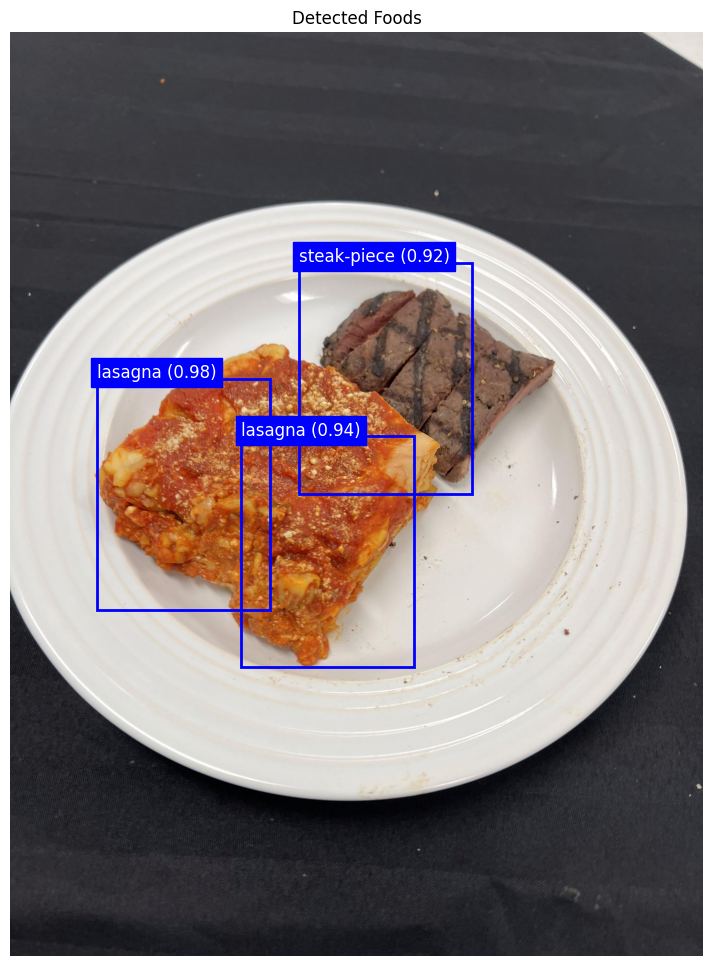

Detected 3 food items in total.
Detected food items:
1. lasagna id: 25 - (Confidence: 0.98)
2. lasagna id: 25 - (Confidence: 0.94)
3. steak-piece id: 41 - (Confidence: 0.92)


In [7]:
import os, json
# Define constants
IMG_SIZE = 224  # Input size for MobileNetV2

# Load the saved model
model_path = "EfficientNetB0_NoTrain_E64_B128_IMG224.h5"
food_detection_model = tf.keras.models.load_model(model_path)

# Setting paths
base_path = 'nutritionverse-data'
images_path = os.path.join(base_path, 'nutritionverse-manual/nutritionverse-manual/images')
coco_json_path = os.path.join(base_path, 'nutritionverse-manual/nutritionverse-manual/images/_annotations.coco.json')
splits_path = os.path.join(base_path, 'nutritionverse-manual/nutritionverse-manual/updated-manual-dataset-splits.csv')

# Load COCO format image metadata
with open(coco_json_path, 'r') as f:
    coco_data = json.load(f)

# Optionally extract image information from COCO format
coco_images = pd.DataFrame(coco_data['images'])

# Create a mapping from image_id to file_name
image_id_to_filename = {img['id']: img['file_name'] for img in coco_data['images']}
print(f"Created mapping for {len(image_id_to_filename)} image IDs to filenames")


category = coco_data['categories']
# Extract only the 'id' values from the categories
category_ids = [cat['id'] for cat in category]

# Initialize and fit the LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(category_ids)


# Test the detection on a sample image
sample_image_id = random.choice(list(image_id_to_filename.keys()))
sample_filename = image_id_to_filename[sample_image_id]
sample_image_path = os.path.join(images_path, sample_filename)

print(f"Testing food detection on image: {sample_filename}")

# Predict food categories
detected_foods = detect_food_in_image(sample_image_path, food_detection_model, label_encoder)

print("Detected food items:")
for i, food in enumerate(detected_foods):
    print(f"{i+1}. {food['category']} id: {food['class_idx']} - (Confidence: {food['confidence']:.2f})")

